In [ ]:
# @title Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import gc
import ast
import json
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from scipy.stats import loguniform, uniform
from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
RND = 42

In [ ]:
# @title Mount Google Drive & Path Configuration
from google.colab import drive
drive.mount('/content/drive/')

project_path = "/content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern/"
data_path = f"{project_path}/Datasets"
output_path = f"{project_path}/Outputs/All Outputs"
import os
os.makedirs(output_path, exist_ok=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# @title Utility Fuction
# Utility helpers untuk EDA
def read_csv(path, **kwargs):
    print("Reading:", path)
    return pd.read_csv(path, **kwargs)

def save_fig(fig, name):
    p = os.path.join(output_path, name)
    fig.savefig(p, bbox_inches='tight', dpi=150)
    print("Saved plot:", p)

def missing_report(df, top=None):
    miss = df.isnull().sum()
    miss = miss[miss>0].sort_values(ascending=False)
    miss_df = miss.to_frame(name='n_missing').assign(pct=lambda d: np.round(d['n_missing'] / len(df) * 100, 2))
    return miss_df.head(top)

def quick_num_summary(df, cols=None, top=None):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns
    summary = df[cols].describe().T
    summary['na_pct'] = np.round(df[cols].isna().mean() * 100, 2)
    return summary.sort_values('na_pct', ascending=False).head(top)

def top_categories(df, col, n=20):
    vc = df[col].value_counts(dropna=False).head(n)
    return vc.to_frame(col)

def rgb(r,g,b):
    return (r/255, g/255, b/255)

def hist_plot_custom(df, col, bins=50, log=False, color=(203/255,85/255,132/255)):
    fig, ax = plt.subplots(figsize=(6,3.5))
    series = df[col].dropna()
    if log:
        series = np.log1p(series[series>0])
        ax.set_title(f"{col} (log1p)")
    else:
        ax.set_title(col)
    ax.grid(False)
    fig.patch.set_alpha(0)
    ax.set_facecolor('none')
    sns.histplot(series, bins=bins, kde=False, ax=ax,  color=color)
    return fig, ax

def barplot_cat_target(df, cat_col, target_col='TARGET', topn=15, color=(203/255,85/255,132/255)):
    order = df[cat_col].value_counts().index[:topn]
    ct = pd.crosstab(df[cat_col], df[target_col]).loc[order]
    ct_norm = ct.div(ct.sum(axis=1), axis=0)

    if 1 in ct_norm.columns:
        target_positive = 1
    else:
        target_positive = ct_norm.columns.max()

    fig, ax = plt.subplots(figsize=(8, max(4,0.3*len(order))))
    ct_norm[target_positive].plot(kind='barh', ax=ax, color=color)
    ax.set_xlabel(f"PERC {target_col}={target_positive} per {cat_col}")
    ax.set_title(f"{cat_col} vs {target_col} (top {topn})")
    return fig, ax

In [ ]:
# @title Load Dataset
app_train = pd.read_csv(os.path.join(data_path, "application_train.csv"))
app_test  = pd.read_csv(os.path.join(data_path, "application_test.csv"))
bureau    = pd.read_csv(os.path.join(data_path, "bureau.csv"))
prev      = pd.read_csv(os.path.join(data_path, "previous_application.csv"))

# summary columns and rows
for name, df in [
    ('app_train', app_train),
    ('app_test', app_test),
    ('bureau', bureau),
    ('prev', prev),
]:
    print(f"{name:8s} shape: {df.shape}")

app_train shape: (307511, 122)
app_test shape: (48744, 121)
bureau   shape: (1716428, 17)
prev     shape: (1670214, 37)


# Exploratory Data Analysis (EDA)

In [ ]:
# @title Overview
# Count numerical columns
num_cols = app_train.select_dtypes(include=['int64', 'float64']).columns
print(f"Number of numerical columns: {len(num_cols)}")

# Count categorical columns
cat_cols = app_train.select_dtypes(include=['object']).columns
print(f"Number of categorical columns: {len(cat_cols)}")

# Feature TARGET
print("application_train Columns:", len(app_train.columns))
print("TARGET Distribution:")
print(app_train['TARGET'].value_counts(dropna=False))

# Missing values
mr = missing_report(app_train, top=None)
display(mr.head())

# Numeric summary
num_sum = quick_num_summary(app_train, top=None)
display(num_sum.head())

Number of numerical columns: 106
Number of categorical columns: 16
application_train Columns: 122
TARGET Distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64


,n_missing,pct
COMMONAREA_MEDI,214865,69.87
COMMONAREA_MODE,214865,69.87
COMMONAREA_AVG,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43


,count,mean,std,min,25%,50%,75%,max,na_pct
COMMONAREA_AVG,92646.0,0.044621,0.076036,0.0,0.0078,0.0211,0.0515,1.0,69.87
COMMONAREA_MODE,92646.0,0.042553,0.074445,0.0,0.0072,0.0190,0.0490,1.0,69.87
COMMONAREA_MEDI,92646.0,0.044595,0.076144,0.0,0.0079,0.0208,0.0513,1.0,69.87
NONLIVINGAPARTMENTS_MODE,93997.0,0.008076,0.046276,0.0,0.0000,0.0000,0.0039,1.0,69.43
NONLIVINGAPARTMENTS_AVG,93997.0,0.008809,0.047732,0.0,0.0000,0.0000,0.0039,1.0,69.43


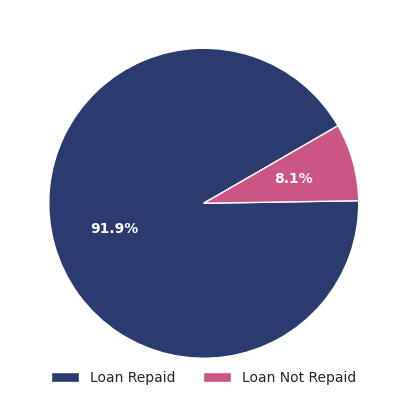

In [ ]:
# @title Data Balanced or Imbalanced
# Hitung jumlah tiap kategori TARGET
temp = app_train["TARGET"].value_counts()
label_map = {0: "Loan Repaid", 1: "Loan Not Repaid"}
labels = temp.index.map(label_map)
sizes = temp.values

# Warna RGB
colors = [(43/255, 58/255, 111/255), (203/255, 85/255, 132/255)]

# Plot pie chart
fig, ax = plt.subplots(figsize=(5, 5), facecolor="none")
wedges, texts, autotexts = ax.pie(sizes,
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=30,
                                  colors=colors,
                                  textprops={'color': "white", 'fontsize': 10, 'fontweight': 'bold'})
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, 0.1),
          ncol=2,
          frameon=False)

fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.subplots_adjust(bottom=0)
plt.savefig("loan_pie.png", dpi=1000, transparent=True, bbox_inches="tight")
plt.show()

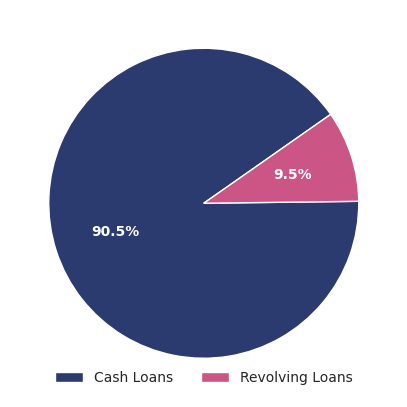

In [ ]:
# @title Types of Loan
# Hitung jumlah tiap kategori TARGET
temp = app_train["NAME_CONTRACT_TYPE"].value_counts()
label_map = {"Cash loans": "Cash Loans", "Revolving loans": "Revolving Loans"}
labels = temp.index.map(label_map)
sizes = temp.values

# Warna RGB
colors = [(43/255, 58/255, 111/255), (203/255, 85/255, 132/255)]

# Plot pie chart
fig, ax = plt.subplots(figsize=(5, 5), facecolor="none")
wedges, texts, autotexts = ax.pie(sizes,
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=35,
                                  colors=colors,
                                  textprops={'color': "white", 'fontsize': 10, 'fontweight': 'bold'})
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, 0.1),
          ncol=2,
          frameon=False)

fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.subplots_adjust(bottom=0)
plt.savefig("loan_pie.png", dpi=1000, transparent=True, bbox_inches="tight")
plt.show()

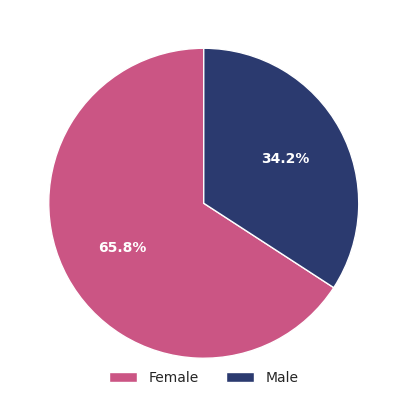

In [ ]:
# @title Applicant's Gender Pie Chart
# Hitung jumlah tiap kategori TARGET
# Ambil hanya kategori M dan F
temp = app_train.loc[train["CODE_GENDER"].isin(["M", "F"]), "CODE_GENDER"].value_counts()
label_map = {"F": "Female", "M": "Male"}
labels = temp.index.map(label_map)
sizes = temp.values

color_map = {"Male": (43/255, 58/255, 111/255),
             "Female": (203/255, 85/255, 132/255)}
colors = [color_map[label] for label in labels]

# Plot pie chart
fig, ax = plt.subplots(figsize=(5, 5), facecolor="none")
wedges, texts, autotexts = ax.pie(sizes,
                                  labels=None,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  colors=colors,
                                  textprops={'color': "white", 'fontsize': 10, 'fontweight': 'bold'})
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, 0.1),
          ncol=2,
          frameon=False)

fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.subplots_adjust(bottom=0.1)
plt.savefig("gender_pie.png", dpi=1000, transparent=True, bbox_inches="tight")
plt.show()

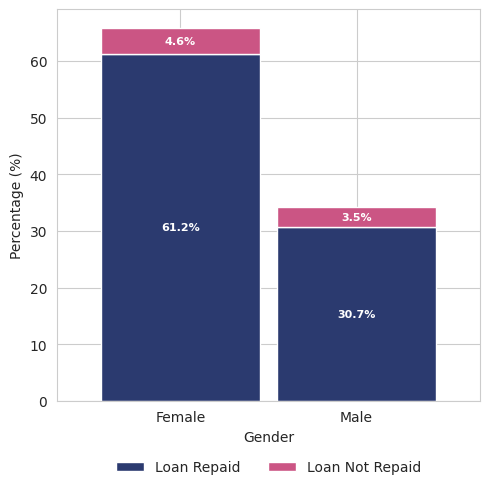

In [ ]:
# @title Applicant's Gender vs TARGET (StackBar)
ct = pd.crosstab(app_train.loc[train["CODE_GENDER"].isin(["M", "F"]), "CODE_GENDER"], app_train["TARGET"])
ct.index = ct.index.map({"M": "Male", "F": "Female"})
ct_pct_total = ct / ct.values.sum() * 100

color_map = {0: (43/255, 58/255, 111/255),   # Biru = Loan Repaid
             1: (203/255, 85/255, 132/255)}  # Pink = Loan Not Repaid

# Plot stacked bar
ax = ct_pct_total.plot(kind="bar",
                 stacked=True,
                 color=[color_map[col] for col in ct_pct_total.columns],
                 figsize=(5,5),
                 width=0.9)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:
      ax.text(x + width/2,
              y + height/2,
              f"{height:.1f}%",
              ha="center", va="center",
              fontsize=8, color="white", fontweight="bold")
ax.legend(["Loan Repaid", "Loan Not Repaid"],
         loc="upper center",
         bbox_to_anchor=(0.5, -0.12),
         ncol=2,
         frameon=False)

ax.set_facecolor("none")
ax.figure.patch.set_alpha(0)
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("gender_stack.png", dpi=1000, transparent=True)
plt.show()

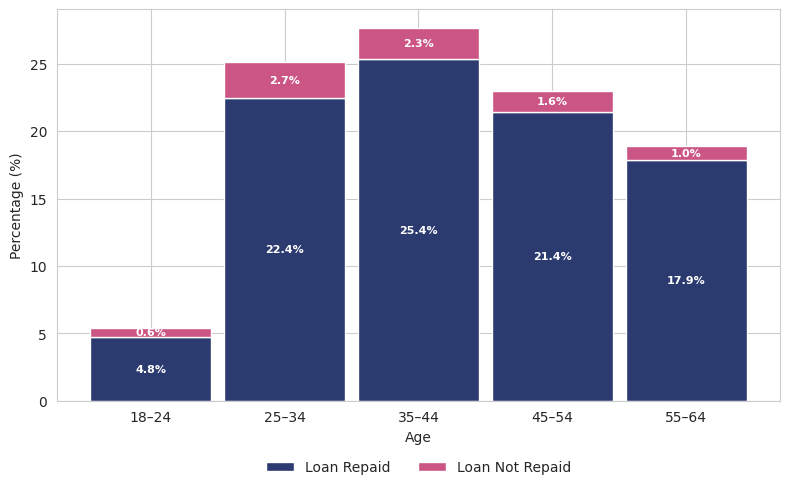

In [ ]:
# @title Applicant's Days Birth
# Konversi ke umur dalam tahun & Buat Kategori
app_train["AGE"] = (-app_train["DAYS_BIRTH"] / 365).astype(int)
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ["18–24", "25–34", "35–44", "45–54", "55–64", "65+"]
app_train["AGE_GROUP"] = pd.cut(app_train["AGE"], bins=bins, labels=labels, right=True)

ct = pd.crosstab(app_train["AGE_GROUP"], app_train["TARGET"])
ct = ct.drop("65+", errors="ignore")
ct_pct_total = ct / ct.values.sum() * 100

color_map = {0: (43/255, 58/255, 111/255),   # Biru = Loan Repaid
             1: (203/255, 85/255, 132/255)}  # Pink = Loan Not Repaid

# Plot stacked bar
ax = ct_pct_total.plot(kind="bar",
                 stacked=True,
                 color=[color_map[col] for col in ct_pct_total.columns],
                 figsize=(8,5),
                 width=0.9)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2,
                y + height/2,
                f"{height:.1f}%",
                ha="center", va="center",
                fontsize=8, color="white", fontweight="bold")
ax.legend(["Loan Repaid", "Loan Not Repaid"],
          loc="upper center",
          bbox_to_anchor=(0.5, -0.12),
          ncol=2,
          frameon=False)

ax.set_facecolor("none")
ax.figure.patch.set_alpha(0)
plt.xlabel("Age")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("agegroup_stack.png", dpi=1000, transparent=True)
plt.show()

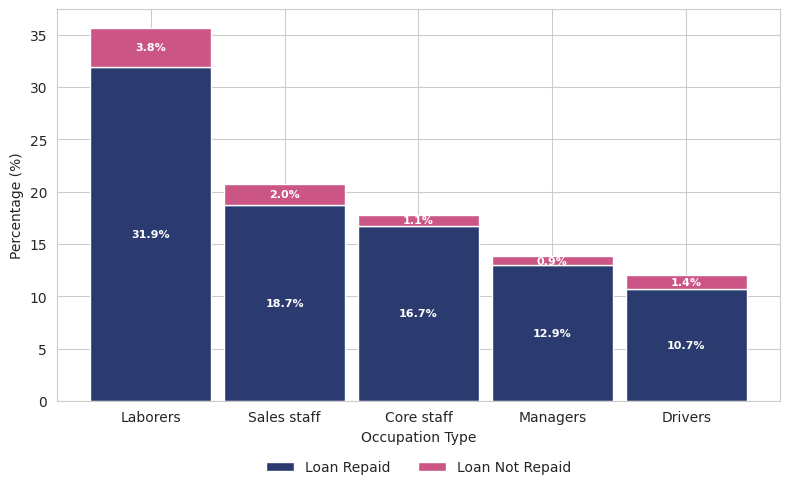

In [ ]:
# @title Applicant's Occupation
top5_occ = app_train["OCCUPATION_TYPE"].value_counts().nlargest(5).index
df_occ = app_train[app_train["OCCUPATION_TYPE"].isin(top5_occ)]

ct = pd.crosstab(df_occ["OCCUPATION_TYPE"], df_occ["TARGET"])
ct_pct_total = ct / ct.values.sum() * 100
ct_pct_total = ct_pct_total.loc[ct_pct_total.sum(axis=1).sort_values(ascending=False).index]

color_map = {0: (43/255, 58/255, 111/255),   # Biru = Loan Repaid
             1: (203/255, 85/255, 132/255)}  # Pink = Loan Not Repaid

ax = ct_pct_total.plot(kind="bar",
                 stacked=True,
                 color=[color_map[col] for col in ct_pct_total.columns],
                 figsize=(8,5),
                 width=0.9)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:  # biar teks 0% tidak muncul
        ax.text(x + width/2,
                y + height/2,
                f"{height:.1f}%",
                ha="center", va="center",
                fontsize=8, color="white", fontweight="bold")
ax.legend(["Loan Repaid", "Loan Not Repaid"],
          loc="upper center",
          bbox_to_anchor=(0.5, -0.12),
          ncol=2,
          frameon=False)

ax.set_facecolor("none")
ax.figure.patch.set_alpha(0)
plt.xlabel("Occupation Type")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("occupation_stack.png", dpi=1000, transparent=True)
plt.show()

# Feature Extraction

In [ ]:
drop_cols = ['TARGET','AGE','AGE_GROUP']
X_train = df_train_merged.drop(columns=drop_cols, errors='ignore')
y_train = df_train_merged['TARGET']
X_test  = df_test_merged.drop(columns=['AGE','AGE_GROUP'], errors='ignore')

In [ ]:
# @title Aggregate to SK_ID_CURR (bureau.csv)
# Aggregate bureau per SK_ID_CURR
agg_bureau = bureau.groupby('SK_ID_CURR').agg(
    bureau_count=('SK_ID_BUREAU', 'count'),
    bureau_amt_credit_sum=('AMT_CREDIT_SUM', 'sum'),
    bureau_amt_credit_mean=('AMT_CREDIT_SUM', 'mean'),
    bureau_amt_credit_max=('AMT_CREDIT_SUM', 'max'),
    bureau_amt_credit_debt_sum=('AMT_CREDIT_SUM_DEBT', 'sum'),
    bureau_amt_credit_debt_mean=('AMT_CREDIT_SUM_DEBT', 'mean'),
    bureau_amt_credit_overdue_sum=('AMT_CREDIT_SUM_OVERDUE', 'sum'),
    bureau_amt_credit_overdue_mean=('AMT_CREDIT_SUM_OVERDUE', 'mean'),
    bureau_credit_day_overdue_mean=('CREDIT_DAY_OVERDUE', 'mean'),
    bureau_cnt_credit_prolong_sum=('CNT_CREDIT_PROLONG', 'sum'),
).reset_index()
agg_bureau.to_csv(os.path.join(output_path, "bureau_agg_per_curr.csv"), index=False)
display(agg_bureau.head())

,SK_ID_CURR,bureau_count,bureau_amt_credit_sum,bureau_amt_credit_mean,bureau_amt_credit_max,bureau_amt_credit_debt_sum,bureau_amt_credit_debt_mean,bureau_amt_credit_overdue_sum,bureau_amt_credit_overdue_mean,bureau_credit_day_overdue_mean,bureau_cnt_credit_prolong_sum
0,100001,7,1453365.000,207623.571429,378000.0,596686.5,85240.928571,0.0,0.0,0.0,0
1,100002,8,865055.565,108131.945625,450000.0,245781.0,49156.200000,0.0,0.0,0.0,0
2,100003,4,1017400.500,254350.125000,810000.0,0.0,0.000000,0.0,0.0,0.0,0
3,100004,2,189037.800,94518.900000,94537.8,0.0,0.000000,0.0,0.0,0.0,0
4,100005,3,657126.000,219042.000000,568800.0,568408.5,189469.500000,0.0,0.0,0.0,0


In [ ]:
# @title Aggregate to SK_ID_CURR (previous_application.csv)
agg_prev = prev.groupby('SK_ID_CURR').agg(
    prev_count=('SK_ID_PREV','count'),
    prev_amt_app_mean=('AMT_APPLICATION','mean'),
    prev_amt_credit_mean=('AMT_CREDIT','mean'),
    prev_amt_credit_max=('AMT_CREDIT','max'),
    prev_cnt_payment_mean=('CNT_PAYMENT','mean'),
    prev_days_decision_mean=('DAYS_DECISION','mean')
).reset_index()
agg_prev.to_csv(os.path.join(output_path, "prev_agg_per_curr.csv"), index=False)
display(agg_prev.head())

,SK_ID_CURR,prev_count,prev_amt_app_mean,prev_amt_credit_mean,prev_amt_credit_max,prev_cnt_payment_mean,prev_days_decision_mean
0,100001,1,24835.50,23787.00,23787.0,8.0,-1740.0
1,100002,1,179055.00,179055.00,179055.0,24.0,-606.0
2,100003,3,435436.50,484191.00,1035882.0,10.0,-1305.0
3,100004,1,24282.00,20106.00,20106.0,4.0,-815.0
4,100005,2,22308.75,20076.75,40153.5,12.0,-536.0


In [ ]:
# Merge to application_train
df_train_merged = (
    app_train.copy()
    .merge(agg_bureau, on='SK_ID_CURR', how='left')
    .merge(agg_prev, on='SK_ID_CURR', how='left')
)

# Merge to application_test
df_test_merged = (
    app_test.copy()
    .merge(agg_bureau, on='SK_ID_CURR', how='left')
    .merge(agg_prev, on='SK_ID_CURR', how='left')
)

# Info ukuran dataset
print("Train shape after merging:", df_train_merged.shape)
print("Test shape after merging:", df_test_merged.shape)

# Simpan hasil merge
df_train_merged.to_csv(os.path.join(output_path, "train_merged.csv"), index=False)
df_test_merged.to_csv(os.path.join(output_path, "test_merged.csv"), index=False)

print("✅ Merging selesai, file disimpan di:", output_path)

Train shape after merging: (307511, 138)
Test shape after merging: (48744, 137)
✅ Merging selesai, file disimpan di: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern//Outputs/All Outputs


# Data Preprocessing

In [ ]:
# @title Load Data
train_path = f"{output_path}/train_merged.csv"
test_path  = f"{output_path}/test_merged.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# Display Train
print("Train shape:", train.shape)
display(train.head())

# Display Test
print("Test shape:", test.shape)
display(test.head())

# Pastikan kolom penting ada
assert 'TARGET' in train.columns, "TARGET column is missing in train dataset!"
assert 'SK_ID_CURR' in train.columns and 'SK_ID_CURR' in test.columns, "SK_ID_CURR column must exist in both train & test"

Train shape: (307511, 138)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_amt_credit_overdue_sum,bureau_amt_credit_overdue_mean,bureau_credit_day_overdue_mean,bureau_cnt_credit_prolong_sum,prev_count,prev_amt_app_mean,prev_amt_credit_mean,prev_amt_credit_max,prev_cnt_payment_mean,prev_days_decision_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,179055.00,179055.00,179055.0,24.000000,-606.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,3.0,435436.50,484191.00,1035882.0,10.000000,-1305.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,1.0,24282.00,20106.00,20106.0,4.000000,-815.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,9.0,272203.26,291695.50,906615.0,23.000000,-272.444444
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,6.0,150530.25,166638.75,284400.0,20.666667,-1222.833333


Test shape: (48744, 137)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,bureau_amt_credit_overdue_sum,bureau_amt_credit_overdue_mean,bureau_credit_day_overdue_mean,bureau_cnt_credit_prolong_sum,prev_count,prev_amt_app_mean,prev_amt_credit_mean,prev_amt_credit_max,prev_cnt_payment_mean,prev_days_decision_mean
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,1.0,24835.50,23787.000,23787.0,8.000000,-1740.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,2.0,22308.75,20076.750,40153.5,12.000000,-536.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,4.0,130871.25,146134.125,512370.0,17.333333,-837.5
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,5.0,49207.50,92920.500,225000.0,11.333333,-1124.2
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,2.0,267727.50,300550.500,508495.5,24.000000,-466.0


In [ ]:
# @title Drop identifier columns and Separate target

# Drop identifier columns
train_proc = train.drop(columns=['SK_ID_CURR'])
test_proc  = test.drop(columns=['SK_ID_CURR'])

# Separate Target
y = train_proc['TARGET']
X = train_proc.drop(columns=['TARGET'])

# Display
print("X shape:", X.shape)
display(X.head())

print("y shape:", y.shape)
display(y.head())

print("Test_proc shape:", test_proc.shape)
display(test_proc.head())

X shape: (307511, 136)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,bureau_amt_credit_overdue_sum,bureau_amt_credit_overdue_mean,bureau_credit_day_overdue_mean,bureau_cnt_credit_prolong_sum,prev_count,prev_amt_app_mean,prev_amt_credit_mean,prev_amt_credit_max,prev_cnt_payment_mean,prev_days_decision_mean
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,1.0,179055.00,179055.00,179055.0,24.000000,-606.000000
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.0,0.0,0.0,0.0,3.0,435436.50,484191.00,1035882.0,10.000000,-1305.000000
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,1.0,24282.00,20106.00,20106.0,4.000000,-815.000000
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,9.0,272203.26,291695.50,906615.0,23.000000,-272.444444
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,6.0,150530.25,166638.75,284400.0,20.666667,-1222.833333


y shape: (307511,)


,TARGET
0,1
1,0
2,0
3,0
4,0


Test_proc shape: (48744, 136)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,bureau_amt_credit_overdue_sum,bureau_amt_credit_overdue_mean,bureau_credit_day_overdue_mean,bureau_cnt_credit_prolong_sum,prev_count,prev_amt_app_mean,prev_amt_credit_mean,prev_amt_credit_max,prev_cnt_payment_mean,prev_days_decision_mean
0,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,1.0,24835.50,23787.000,23787.0,8.000000,-1740.0
1,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,2.0,22308.75,20076.750,40153.5,12.000000,-536.0
2,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,0.0,0.0,0.0,0.0,4.0,130871.25,146134.125,512370.0,17.333333,-837.5
3,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,5.0,49207.50,92920.500,225000.0,11.333333,-1124.2
4,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,NaN,NaN,NaN,NaN,2.0,267727.50,300550.500,508495.5,24.000000,-466.0


In [ ]:
# @title Check Missing Values
missing_train = X.isnull().sum()
missing_train_percent = (X.isnull().mean() * 100).sort_values(ascending=False)
missing_summary = pd.DataFrame({'Missing Values': missing_train,
                                'Percentage (%)': missing_train_percent}).sort_values(by='Percentage (%)', ascending=False)
print("Missing values in train:")
display(missing_summary.head(10))

Missing values in train:


,Missing Values,Percentage (%)
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


In [ ]:
# @title Imputation Missing Values
# Hitung missing
missing_summary = X.isnull().mean().sort_values(ascending=False)
cols_high_missing = missing_summary[missing_summary > 0.60].index.tolist()
print(f"Dropping {len(cols_high_missing)} cols with >60% missing")

# Drop kolom yang super kosong
X_proc = X.drop(columns=cols_high_missing)
test_proc = test_proc.drop(columns=cols_high_missing, errors='ignore')

# Buat missing flag untuk kolom penting
important_cols = [c for c in X_proc.columns
                  if any (ext in c for ext in ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"])]
for col in important_cols:
    X_proc[col + "_MISSING_FLAG"] = X_proc[col].isnull().astype(int)
    test_proc[col + "_MISSING_FLAG"] = test_proc[col].isnull().astype(int)

# Imputasi
num_cols = X_proc.select_dtypes(include=['int64','float64']).columns
cat_cols = X_proc.select_dtypes(include=['object']).columns

# numeric imputer
num_imputer = SimpleImputer(strategy='median')
X_proc[num_cols] = num_imputer.fit_transform(X_proc[num_cols])
test_proc[num_cols] = num_imputer.transform(test_proc[num_cols])

# categorical imputer
cat_imputer = SimpleImputer(strategy='most_frequent')
X_proc[cat_cols] = cat_imputer.fit_transform(X_proc[cat_cols])
test_proc[cat_cols] = cat_imputer.transform(test_proc[cat_cols])

# Verify no more missing values
print("Missing after preprocessing (train):", X_proc.isnull().sum().sum())
print("Missing after preprocessing (test):", test_proc.isnull().sum().sum())

Dropping 17 cols with >60% missing
Missing after preprocessing (train): 0
Missing after preprocessing (test): 0


In [ ]:
# @title Encoding Categorical
if len(cat_cols) > 0:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_cat_encoded = ohe.fit_transform(X_proc[cat_cols])
    test_cat_encoded = ohe.transform(test_proc[cat_cols])
    X_cat_df = pd.DataFrame(X_cat_encoded, columns=ohe.get_feature_names_out(cat_cols), index=X_proc.index)
    test_cat_df = pd.DataFrame(test_cat_encoded, columns=ohe.get_feature_names_out(cat_cols), index=test_proc.index)

    # gabungkan kembali numeric + categorical encoded
    X_final = pd.concat([X_proc[num_cols], X_cat_df], axis=1)
    test_final = pd.concat([test_proc[num_cols], test_cat_df], axis=1)
else:
    print("⚠️ No categorical columns found. Proceeding with numeric only.")
    X_final = X_proc.copy()
    test_final = test_proc.copy()

print("Train encoded sample:")
display(X_final.head())
print("\nTest encoded sample:")
display(test_final.head())
print("✅ Encoding selesai. Final shape:", X_final.shape, test_final.shape)

Train encoded sample:


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0



Test encoded sample:


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241.0,-2329.0,-5170.0,-812.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,-13040.0,-2191.0,-4000.0,-4262.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


✅ Encoding selesai. Final shape: (307511, 243) (48744, 243)


In [ ]:
# @title Scaling
num_cols_final = X_final.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

X_final.loc[:, num_cols_final] = scaler.fit_transform(X_final[num_cols_final])
test_final.loc[:, num_cols_final] = scaler.transform(test_final[num_cols_final])

print("Train final setelah scaling:")
display(X_final.head())
print("\nTest final setelah scaling:")
display(test_final.head())
print("✅ Scaling selesai. Numerik sudah terstandarisasi (mean=0, std=1).")
print("Train scaled shape:", X_final.shape)
print("Test scaled shape :", test_final.shape)

Train final setelah scaling:


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-1.616246,1.935056,-0.133215,0.08734,-0.08734
1,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,-0.062904,5.677469,-0.086733,-0.076281,-0.072886,-1.616246,-0.516781,-0.133215,0.08734,-0.08734
2,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,0.618718,-0.516781,-0.133215,0.08734,-0.08734
3,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,0.618718,-0.516781,-0.133215,0.08734,-0.08734
4,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,0.618718,-0.516781,-0.133215,0.08734,-0.08734



Test final setelah scaling:


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,-0.577538,-0.142533,-0.075097,-0.451790,-0.239153,-0.145910,-0.734193,-0.468192,-0.052196,1.445696,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,-1.616246,1.935056,-0.133215,0.08734,-0.08734
1,-0.577538,-0.294354,-0.934825,-0.671924,-0.970289,1.078997,-0.464485,-0.483339,-1.172870,0.908413,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,0.618718,-0.516781,-0.133215,0.08734,-0.08734
2,-0.577538,0.142129,0.159601,2.943988,0.248271,-0.127762,-0.916824,-0.483262,0.797961,-0.337075,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,0.618718,-0.516781,-0.133215,0.08734,-0.08734
3,2.192084,0.616567,2.424840,1.511720,2.807247,0.399377,0.472274,-0.464915,0.847636,-0.804133,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,0.618718,-0.516781,-0.133215,0.08734,-0.08734
4,0.807273,0.047242,0.065776,0.342121,0.236086,-0.783451,0.686757,-0.467215,0.279919,-0.839908,...,-0.062904,-0.176135,-0.086733,-0.076281,-0.072886,0.618718,-0.516781,-0.133215,0.08734,-0.08734


✅ Scaling selesai. Numerik sudah terstandarisasi (mean=0, std=1).
Train scaled shape: (307511, 243)
Test scaled shape : (48744, 243)


In [ ]:
# @title Feature Selection
rf = RandomForestClassifier(n_estimators=200,
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             n_jobs=-1,
                             random_state=42)
rf.fit(X_final, y)

# Feature selection
sfm_rf = SelectFromModel(rf, prefit=True, threshold='median')
selected_features_names = X_final.columns[sfm_rf.get_support()]

X_selected = X_final[selected_features_names].copy()
test_selected = test_final[selected_features_names].copy()

print("\n✅ Feature Selection Selesai")
print(f"Jumlah fitur terpilih: {len(selected_features_names)} dari total {X_final.shape[1]}")
print("Contoh fitur terpilih:", list(selected_features_names[:10]))
print("\nShape dataset setelah feature selection:")
print("X_selected :", X_selected.shape)
print("test_selected:", test_selected.shape)


✅ Feature Selection Selesai
Jumlah fitur terpilih: 122 dari total 243
Contoh fitur terpilih: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']

Shape dataset setelah feature selection:
X_selected : (307511, 122)
test_selected: (48744, 122)


In [ ]:
num_cols_base = X_proc.select_dtypes(include=['int64', 'float64']).columns
selected_num_cols_count = len([col for col in selected_features_names if col in num_cols_base])
selected_cat_cols_count = len(selected_features_names) - selected_num_cols_count

print("Jumlah fitur setelah feature selection:")
print(f"Number of selected numerical columns: {selected_num_cols_count}")
print(f"Number of selected categorical columns: {selected_cat_cols_count}")

Jumlah fitur setelah feature selection:
Number of selected numerical columns: 81
Number of selected categorical columns: 41


In [ ]:
# @title Save Dataset Scaling
train_scaled_full = pd.concat([y.reset_index(drop=True), X_selected.reset_index(drop=True)], axis=1)
train_scaled_path = os.path.join(output_path, 'train_selected_scaled.csv')
train_scaled_full.to_csv(train_scaled_path, index=False)

test_scaled_path = os.path.join(output_path, 'test_selected_scaled.csv')
test_selected.to_csv(test_scaled_path, index=False)

print("✅ Dataset hasil feature selection (sudah di-scaling) berhasil disimpan.")
print(f"Train scaled shape: {train_scaled_full.shape}")
print(f"Test  scaled shape: {test_selected.shape}")
print(f"File disimpan di: {output_path}")

✅ Dataset hasil feature selection (sudah di-scaling) berhasil disimpan.
Train scaled shape: (307511, 123)
Test  scaled shape: (48744, 122)
File disimpan di: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern//Outputs/All Outputs


In [ ]:
# @title Save Dataset NoScaled
X_selected_unscaled = X_final[selected_features_names].copy()
test_selected_unscaled = test_final[selected_features_names].copy()

train_unscaled_full = pd.concat([y.reset_index(drop=True), X_selected_unscaled.reset_index(drop=True)], axis=1)

train_unscaled_path = os.path.join(output_path, 'train_selected_unscaled.csv')
train_unscaled_full.to_csv(train_unscaled_path, index=False)

test_unscaled_path = os.path.join(output_path, 'test_selected_unscaled.csv')
test_selected_unscaled.to_csv(test_unscaled_path, index=False)

print("✅ Dataset hasil feature selection (belum di-scaling) berhasil disimpan.")
print(f"Train unscaled shape: {train_unscaled_full.shape}")
print(f"Test  unscaled shape: {test_selected_unscaled.shape}")
print(f"File disimpan di: {output_path}")

✅ Dataset hasil feature selection (belum di-scaling) berhasil disimpan.
Train unscaled shape: (307511, 123)
Test  unscaled shape: (48744, 122)
File disimpan di: /content/drive/MyDrive/Project/PBI Home Credit Indonesia-Data Scientist Intern//Outputs/All Outputs
